This file is a demonstration of how the deep learning models were trained in practice for the poster presentation.

We begin by mounting the drive and reading the set of features. The program to convert a BAM file to this set of features will be included in the final github repo.

In [ ]:
#mounting drive and importing data
from google.colab import drive
drive.mount("/content/drive")
import pandas as pd
import numpy as np
df = pd.read_table('/content/drive/My Drive/FeatureSet2.withheader.txt')

Mounted at /content/drive


Using pandas, we shuffle the data and filter out the Genotype labels into a second dataset.

In [ ]:
#seperating targets from training data
def shuffle_sep(df):
  df = df.sample(frac=1)
  df_targy = df.filter(regex='Genotype')
  df_targy['Genotype'] = pd.factorize(df['Genotype'])[0]
  df = df.drop('Genotype', 1)
  return df, df_targy
def shuffle_sep_G(df):
  df = df.sample(frac=1)
  df_targy = df.filter(regex='Genotype')
  Genotypes = df_targy.Genotype.unique()
  df_targy['Genotype'] = pd.factorize(df['Genotype'])[0]
  df = df.drop('Genotype', 1)
  return df, df_targy, Genotypes
df, df_targy, Genotypes = shuffle_sep_G(df)
def just_sep(df):
  df_targy = df.filter(regex='Genotype')
  df = df.drop('Genotype', 1)
  return df, df_targy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


Next, we transfer the pandas dataframes to numpy arrays, which Keras takes as input.

In [ ]:
#initializing numpy arrays
def sets_numpy(df, df_targy):
  train = df.to_numpy()
  targy = df_targy.to_numpy()
  return train, targy


One-hot encoding is then employed on the labels, which is necessary for a classification problem like this one.

In [ ]:
#vectorization
from keras.utils.np_utils import to_categorical
def vectorize_and_holdout(train, targy):
  v_train = train
  v_targy = to_categorical(targy)
  return v_train, v_targy


This function allows us to define hyperparameters for k-fold validation. Edit the final line to play around with the results! All of the cells after this are only there for data vizualization purposes.

In [ ]:
#k-fold validation training
from keras import models
from keras import layers
from keras import regularizers
def run_thalia(input, trainset, targyset, k, num_epochs, numlayers, weights, kernel, dropout):
  all_scores = []
  all_losses = []
  all_tlosses = []
  num_val_samples = len(trainset) // k
  all_scores = []
  for i in range(k):
    model = models.Sequential()
    model.add(layers.Dense(weights, kernel_regularizer=regularizers.l2(0.001),
                        activation='relu', input_shape=(input,)))
    for j in range(numlayers):
      if kernel == True:
        model.add(layers.Dense(weights, kernel_regularizer=regularizers.l2(0.001),
                        activation='relu'))
      if kernel != True:
        model.add(layers.Dense(weights, activation='relu'))
      if dropout == True:
        model.add(layers.Dropout(0.25))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print('processing fold #', i + 1)
    val_data = trainset[i * num_val_samples: (i + 1) * num_val_samples]
    val_targy = targyset[i * num_val_samples: (i + 1) * num_val_samples]

    partial_v_train = np.concatenate(
        [trainset[:i * num_val_samples],
        trainset[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_v_targy = np.concatenate(
        [targyset[:i * num_val_samples],
        targyset[(i + 1) * num_val_samples:]],
        axis = 0)
    history = model.fit(partial_v_train, partial_v_targy, epochs= num_epochs, batch_size=512, verbose = 0, validation_data = (val_data, val_targy))
    val_loss, val_mae = model.evaluate(val_data, val_targy, verbose = 0)
    all_scores.append(val_mae)
    print(all_scores)
    print(val_loss)
  return history, model

In [ ]:
def run_thalia_all(input, trainset, targyset, num_epochs, numlayers, weights, kernel, dropout):
  all_scores = []
  all_losses = []
  all_tlosses = []
  num_val_samples = len(trainset)
  all_scores = []
  model = models.Sequential()
  if kernel==True:
    model.add(layers.Dense(weights, kernel_regularizer=regularizers.l2(0.001),
                      activation='relu', input_shape=(input,)))
  else:
      model.add(layers.Dense(weights,
                      activation='relu', input_shape=(input,)))
  for j in range(numlayers):
    if kernel == True:
      model.add(layers.Dense(weights, kernel_regularizer=regularizers.l2(0.001),
                      activation='relu'))
    if kernel != True:
      model.add(layers.Dense(weights, activation='relu'))
    if dropout == True:
      model.add(layers.Dropout(0.25))
  model.add(layers.Dense(6, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  print('processing')
  history = model.fit(trainset, targyset, epochs= num_epochs, batch_size=512, verbose = 0, validation_split= 0.01)
  return history, model

In [ ]:
cdf2 = pd.read_table('/content/drive/My Drive/DataSet2.11760samples.cvg30.insert440.stdev100.hg19.txt')
cdf2, cdf2_targy, Genotypes = shuffle_sep_G(cdf2)
print(cdf2_targy[0:20])
ctrain2, ctargy2 = sets_numpy(cdf2, cdf2_targy)
v_train, v_targy = vectorize_and_holdout(ctrain2, ctargy2)
endhistory, endmodel = run_thalia_all(1290, v_train, v_targy, 6, 6, 512, True, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


      Genotype
3895         0
976          1
309          2
3050         3
1739         4
2655         3
1765         4
694          1
3728         0
2444         5
403          2
2046         5
1715         4
2492         5
3131         3
3443         0
1785         4
2248         5
1067         1
1412         4
processing


In [ ]:
from keras.engine.data_adapter import pack_x_y_sample_weight
print(endhistory.history['val_accuracy'])
realdata = pd.read_table('/content/drive/My Drive/RealSamples.unnormalized.nogenotypes.hg19.test.norm.maskedgenos.final.txt')
realdata, trash = just_sep(realdata)
realdata = realdata.to_numpy()
print(realdata)
predictions = endmodel.predict(realdata)
print(predictions)
finalpredicts = []
def genetest():
  for i in predictions:
    bestval = 0
    for index, value in enumerate(i):
      if i[index] > bestval:
        bestval = i[index]
        bestindex = index
    finalpredicts.append(Genotypes[bestindex])
with open('predictions_prob.txt', 'w') as f:
  for G in Genotypes:
    f.write(G + "\t")
  for i in predictions:
    for index, value in enumerate(i):
      f.write(str(value) + "\t")
    f.write('\n')
genetest()
with open('predictions_best.txt', 'w') as f:
  for p in finalpredicts:
    f.write(p + '\n')

[0.17499999701976776, 0.375, 0.375, 0.7250000238418579, 0.824999988079071, 0.8999999761581421]
[[46 43 51 ...  0  0  0]
 [48 37 45 ...  0  0  0]
 [40 35 43 ...  0  0  0]
 ...
 [49 46 49 ...  0  0  0]
 [44 41 48 ...  0  0  0]
 [43 32 28 ...  0  0  0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



[[9.6473795e-01 1.5173534e-06 7.3362282e-04 1.3230882e-03 3.3832139e-03
  2.9820492e-02]
 [5.8651194e-03 2.7704433e-08 9.8525059e-01 8.8802576e-03 3.8306175e-06
  1.5017008e-07]
 [2.3669664e-04 6.3798507e-07 2.2393651e-09 4.8381776e-07 1.8671019e-02
  9.8109114e-01]
 ...
 [1.0987089e-03 1.4761019e-07 8.9521528e-09 7.4799959e-07 6.3245576e-03
  9.9257588e-01]
 [2.5763790e-04 1.5720599e-07 1.5052287e-09 2.3143224e-07 9.0495143e-03
  9.9069244e-01]
 [2.4450533e-04 2.5553521e-07 9.7457975e-10 2.7882015e-07 1.5698623e-02
  9.8405635e-01]]


In [ ]:
df4 = pd.read_table('/content/drive/My Drive/DataSet2.cvg10.insert440.stdev100.hg19.txt')
df3 = pd.read_table('/content/drive/My Drive/DataSet2.cvg20.insert440.stdev100.hg19.txt')
df2 = pd.read_table('/content/drive/My Drive/FeatureSet2.bundle2.withheader.txt')
df2, df2_targy = shuffle_sep(df2)
df3, df3_targy = shuffle_sep(df3)
df4, df4_targy = shuffle_sep(df4)
train2, targy2 = sets_numpy(df2, df2_targy)
train3, targy3 = sets_numpy(df3, df3_targy)
train4, targy4 = sets_numpy(df4, df4_targy)
v2_train, v2_targy = vectorize_and_holdout(train2, targy2)
v3_train, v3_targy = vectorize_and_holdout(train3, targy3)
v4_train, v4_targy = vectorize_and_holdout(train4, targy4)
history, model = run_thalia_all(1305, v_train, v_targy, 12, 5, 1024, False, False)
history2, model2 = run_thalia_all(1305, v2_train, v2_targy, 12, 7, 128, False, False)
history3, model3 = run_thalia_all(1290, v3_train, v3_targy, 12, 2, 512, False, False)
history4, model4 = run_thalia_all(1290, v4_train, v4_targy, 12, 8, 256, False, False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


processing
processing
processing
processing


In [ ]:
cdf2 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg30.insert440.stdev100.hg19.txt')
cdf2, cdf2_targy, Genotypes = shuffle_sep_G(cdf2)
ctrain2, ctargy2 = sets_numpy(cdf2, cdf2_targy)
v_train, v_targy = vectorize_and_holdout(ctrain2, ctargy2)

l1, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 16, True, False)
l2, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 32, True, False)
l3, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 64, True, False)
l4, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 128, True, False)
l5, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 256, True, False)
l6, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 512, True, False)
l7, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 1024, True, False)
l8, model = run_thalia_all(1290, v_train, v_targy, 12, 0, 2048, True, False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


      Genotype
202          0
4            0
1666         1
401          2
488          2
407          2
516          2
1063         3
1070         3
1523         4
1731         1
668          5
169          0
1948         1
31           0
1171         3
1122         3
972          5
932          5
624          2
processing
processing
processing
processing
processing
processing
processing
processing


In [ ]:
tcdf3 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg30.insert440.stdev100.chm13.txt')
tcdf3, tcdf3_targy = shuffle_sep(tcdf3)
tctrain3, tctargy3 = sets_numpy(tcdf3, tcdf3_targy)
tcv3_train, tcv3_targy = vectorize_and_holdout(tctrain3, tctargy3)
tl1, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 16, True, False)
tl2, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 32, True, False)
tl3, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 64, True, False)
tl4, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 128, True, False)
tl5, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 256, True, False)
tl6, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 512, True, False)
tl7, model = run_thalia_all(1306, tcv3_train, tcv3_targy, 12, 0, 1024, True, False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


processing
processing
processing
processing
processing
processing
processing


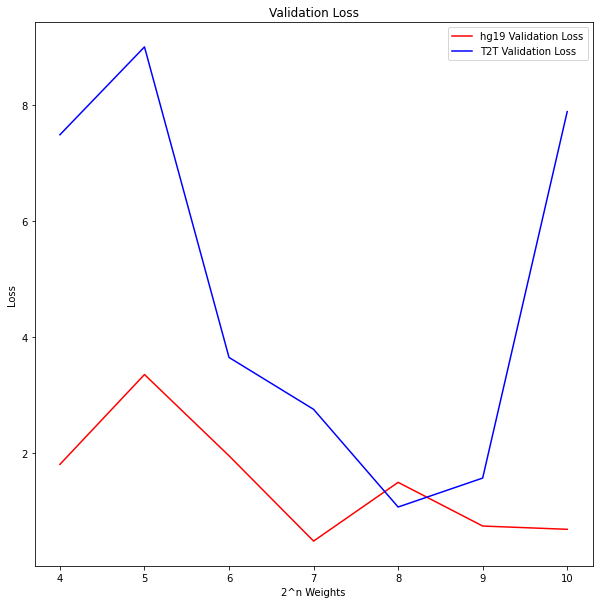

In [ ]:
loss_vall1 = l1.history['val_loss']
loss_vall2 = l2.history['val_loss']
loss_vall3 = l3.history['val_loss']
loss_vall4 = l4.history['val_loss']
loss_vall5 = l5.history['val_loss']
loss_vall6 = l6.history['val_loss']
loss_vall7 = l7.history['val_loss']
tloss_vall1 = tl1.history['val_loss']
tloss_vall2 = tl2.history['val_loss']
tloss_vall3 = tl3.history['val_loss']
tloss_vall4 = tl4.history['val_loss']
tloss_vall5 = tl5.history['val_loss']
tloss_vall6 = tl6.history['val_loss']
tloss_vall7 = tl7.history['val_loss']


loss_valls = [loss_vall1, loss_vall2, loss_vall3, loss_vall4, loss_vall5, loss_vall6, loss_vall7]
last_losses = []
for i in loss_valls:
  last_loss = i[-1]
  last_losses.append(last_loss)

tloss_valls = [tloss_vall1, tloss_vall2, tloss_vall3, tloss_vall4, tloss_vall5, tloss_vall6, tloss_vall7]
tlast_losses = []
for i in tloss_valls:
  tlast_loss = i[-1]
  tlast_losses.append(tlast_loss)

import matplotlib.pyplot as plt
nlayers = range(4, 11)
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(nlayers, last_losses, 'r', label= 'hg19 Validation Loss')
plt.plot(nlayers, tlast_losses, 'b', label='T2T Validation Loss')


plt.title('Validation Loss')

plt.xlabel('2^n Weights')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [ ]:
ll1, model = run_thalia_all(1305, v_train, v_targy, 12, 1, 1024, False, False)
ll2, model = run_thalia_all(1305, v_train, v_targy, 12, 2, 1024, False, False)
ll3, model = run_thalia_all(1305, v_train, v_targy, 12, 3, 1024, False, False)
ll4, model = run_thalia_all(1305, v_train, v_targy, 12, 4, 1024, False, False)
ll5, model = run_thalia_all(1305, v_train, v_targy, 12, 5, 1024, False, False)
ll6, model = run_thalia_all(1305, v_train, v_targy, 12, 6, 1024, False, False)
ll7, model = run_thalia_all(1305, v_train, v_targy, 12, 7, 1024, False, False)
ll8, model = run_thalia_all(1305, v_train, v_targy, 12, 8, 1024, False, False)

processing
processing
processing
processing
processing
processing
processing
processing


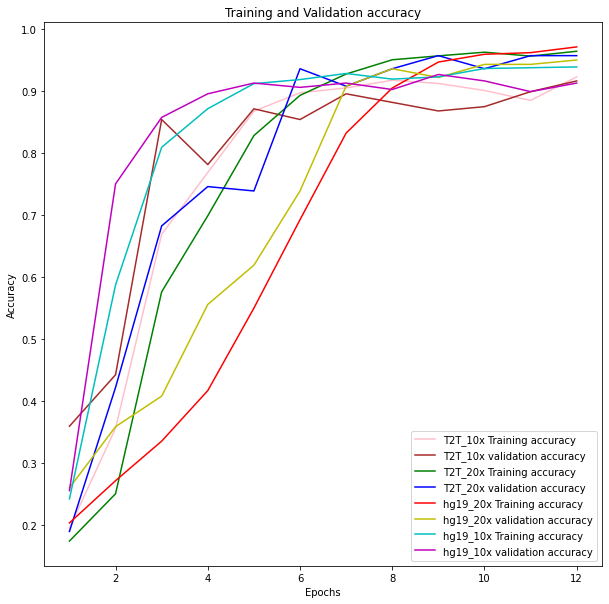

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['accuracy']

loss_val = history.history['val_accuracy']

loss_train2 = history2.history['accuracy']

loss_val2 = history2.history['val_accuracy']

loss_train3 = history3.history['accuracy']

loss_val3 = history3.history['val_accuracy']

loss_train4 = history4.history['accuracy']

loss_val4 = history4.history['val_accuracy']


epochs = range(1,13)
plt.rcParams['figure.figsize'] = [10, 10]


plt.plot(epochs, loss_train, 'pink', label='T2T_10x Training accuracy')

plt.plot(epochs, loss_val, 'brown', label='T2T_10x validation accuracy')

plt.plot(epochs, loss_train2, 'g', label='T2T_20x Training accuracy')

plt.plot(epochs, loss_val2, 'b', label='T2T_20x validation accuracy')

plt.plot(epochs, loss_train3, 'r', label='hg19_20x Training accuracy')

plt.plot(epochs, loss_val3, 'y', label='hg19_20x validation accuracy')

plt.plot(epochs, loss_train4, 'c', label='hg19_10x Training accuracy')

plt.plot(epochs, loss_val4, 'm', label='hg19_10x validation accuracy')


plt.title('Training and Validation accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

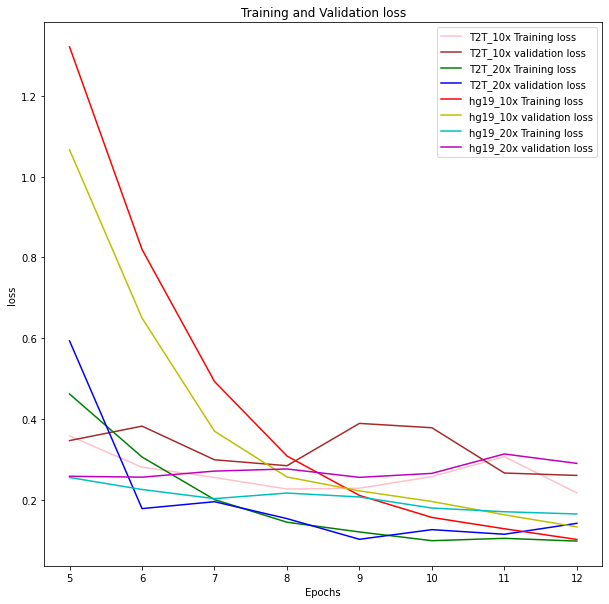

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']

loss_val = history.history['val_loss']

loss_train2 = history2.history['loss']

loss_val2 = history2.history['val_loss']

loss_train3 = history3.history['loss']

loss_val3 = history3.history['val_loss']

loss_train4 = history4.history['loss']

loss_val4 = history4.history['val_loss']


epochs = range(5,13)
plt.rcParams['figure.figsize'] = [10, 10]


plt.plot(epochs, loss_train[4:], 'pink', label='T2T_10x Training loss')

plt.plot(epochs, loss_val[4:], 'brown', label='T2T_10x validation loss')

plt.plot(epochs, loss_train2[4:], 'g', label='T2T_20x Training loss')

plt.plot(epochs, loss_val2[4:], 'b', label='T2T_20x validation loss')

plt.plot(epochs, loss_train3[4:], 'r', label='hg19_10x Training loss')

plt.plot(epochs, loss_val3[4:], 'y', label='hg19_10x validation loss')

plt.plot(epochs, loss_train4[4:], 'c', label='hg19_20x Training loss')

plt.plot(epochs, loss_val4[4:], 'm', label='hg19_20x validation loss')


plt.title('Training and Validation loss')

plt.xlabel('Epochs')

plt.ylabel('loss')

plt.legend()

plt.show()

In [ ]:
cdf4 = pd.read_table('/content/drive/My Drive/DataSet2.11760samples.cvg10.insert440.stdev100.hg19.txt')
cdf3 = pd.read_table('/content/drive/My Drive/DataSet2.11760samples.cvg20.insert440.stdev100.hg19.txt')
cdf2 = pd.read_table('/content/drive/My Drive/DataSet2.11760samples.cvg30.insert440.stdev100.hg19.txt')
cdf1 = pd.read_table('/content/drive/My Drive/DataSet2.11760samples.cvg40.insert440.stdev100.hg19.txt')
cdf1, cdf1_targy = shuffle_sep(cdf1)
cdf2, cdf2_targy = shuffle_sep(cdf2)
cdf3, cdf3_targy = shuffle_sep(cdf3)
cdf4, cdf4_targy = shuffle_sep(cdf4)
ctrain1, ctargy1 = sets_numpy(cdf1, cdf1_targy)
ctrain2, ctargy2 = sets_numpy(cdf2, cdf2_targy)
ctrain3, ctargy3 = sets_numpy(cdf3, cdf3_targy)
ctrain4, ctargy4 = sets_numpy(cdf4, cdf4_targy)
cv1_train, cv1_targy = vectorize_and_holdout(ctrain1, ctargy1)
cv2_train, cv2_targy = vectorize_and_holdout(ctrain2, ctargy2)
cv3_train, cv3_targy = vectorize_and_holdout(ctrain3, ctargy3)
cv4_train, cv4_targy = vectorize_and_holdout(ctrain4, ctargy4)
chistory, cmodel = run_thalia_all(1290, cv1_train, cv1_targy, 10, 7, 1024, False, False)
chistory2, cmodel2 = run_thalia_all(1290, cv2_train, cv2_targy, 10, 4, 1024, False, False)
chistory3, cmodel3 = run_thalia_all(1290, cv3_train, cv3_targy, 10, 8, 256, False, False)
chistory4, cmodel4 = run_thalia_all(1290, cv4_train, cv4_targy, 10, 2, 512, False, False)




ParserError: ignored

In [ ]:
import matplotlib.pyplot as plt

loss_train = chistory.history['loss']

loss_val = chistory.history['val_loss']

loss_train2 = chistory2.history['loss']

loss_val2 = chistory2.history['val_loss']

loss_train3 = chistory3.history['loss']

loss_val3 = chistory3.history['val_loss']

loss_train4 = chistory4.history['loss']

loss_val4 = chistory4.history['val_loss']


epochs = range(1,11)
plt.rcParams['figure.figsize'] = [10, 10]


plt.plot(epochs, loss_train, 'pink', label='40x Training loss')

plt.plot(epochs, loss_val, 'brown', label='40x validation loss')

plt.plot(epochs, loss_train2, 'g', label='30x Training loss')

plt.plot(epochs, loss_val2, 'b', label='30x validation loss')

plt.plot(epochs, loss_train3, 'r', label='20x Training loss')

plt.plot(epochs, loss_val3, 'y', label='20x validation loss')

plt.plot(epochs, loss_train4, 'c', label='10x Training loss')

plt.plot(epochs, loss_val4, 'm', label='10x validation loss')


plt.title('Training and Validation loss')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

NameError: ignored

[0.9108061790466309, 0.9653978943824768, 1.0, 0.9929577708244324]


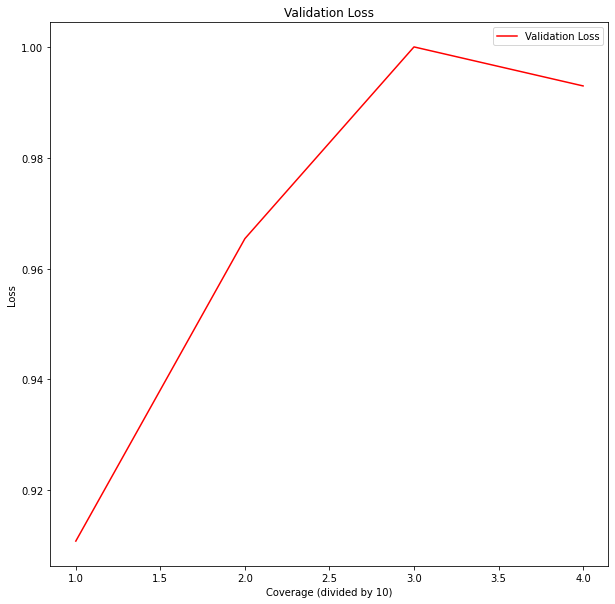

In [ ]:
loss_valls = [loss_val4, loss_val3, loss_val2, loss_val]
last_losses = []
for i in loss_valls:
  last_loss = i[-1]
  last_losses.append(last_loss)
import matplotlib.pyplot as plt
print(last_losses)
nfolds = range(1, 5)
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(nfolds, last_losses, 'r', label='Validation Loss')
plt.title('Validation Loss')

plt.xlabel('Coverage (divided by 10)')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [ ]:
cdf4 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg40.insert440.stdev100.hg19.txt')
cdf3 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg30.insert440.stdev100.hg19.txt')
cdf2 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg20.insert440.stdev100.hg19.txt')
cdf1 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg10.insert440.stdev100.hg19.txt')
cdf1, cdf1_targy = shuffle_sep(cdf1)
cdf2, cdf2_targy = shuffle_sep(cdf2)
cdf3, cdf3_targy = shuffle_sep(cdf3)
cdf4, cdf4_targy = shuffle_sep(cdf4)
ctrain1, ctargy1 = sets_numpy(cdf1, cdf1_targy)
ctrain2, ctargy2 = sets_numpy(cdf2, cdf2_targy)
ctrain3, ctargy3 = sets_numpy(cdf3, cdf3_targy)
ctrain4, ctargy4 = sets_numpy(cdf4, cdf4_targy)
cv1_train, cv1_targy = vectorize_and_holdout(ctrain1, ctargy1)
cv2_train, cv2_targy = vectorize_and_holdout(ctrain2, ctargy2)
cv3_train, cv3_targy = vectorize_and_holdout(ctrain3, ctargy3)
cv4_train, cv4_targy = vectorize_and_holdout(ctrain4, ctargy4)
chistory, cmodel = run_thalia_all(1290, cv1_train, cv1_targy, 12, 6, 1024, True, False)
chistory2, cmodel2 = run_thalia_all(1290, cv2_train, cv2_targy, 12, 8, 128, True, False)
chistory3, cmodel3 = run_thalia_all(1290, cv3_train, cv3_targy, 12, 8, 512, False, False)
chistory4, cmodel4 = run_thalia_all(1290, cv4_train, cv4_targy, 12, 7, 256, False, False)
tcdf4 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg40.insert440.stdev100.chm13.txt')
tcdf3 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg30.insert440.stdev100.chm13.txt')
tcdf2 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg20.insert440.stdev100.chm13.txt')
tcdf1 = pd.read_table('/content/drive/My Drive/DataSet2.5880samples.cvg10.insert440.stdev100.chm13.txt')
tcdf1, tcdf1_targy = shuffle_sep(tcdf1)
tcdf2, tcdf2_targy = shuffle_sep(tcdf2)
tcdf3, tcdf3_targy = shuffle_sep(tcdf3)
tcdf4, tcdf4_targy = shuffle_sep(tcdf4)
tctrain1, tctargy1 = sets_numpy(tcdf1, tcdf1_targy)
tctrain2, tctargy2 = sets_numpy(tcdf2, tcdf2_targy)
tctrain3, tctargy3 = sets_numpy(tcdf3, tcdf3_targy)
tctrain4, tctargy4 = sets_numpy(tcdf4, tcdf4_targy)
tcv1_train, tcv1_targy = vectorize_and_holdout(tctrain1, tctargy1)
tcv2_train, tcv2_targy = vectorize_and_holdout(tctrain2, tctargy2)
tcv3_train, tcv3_targy = vectorize_and_holdout(tctrain3, tctargy3)
tcv4_train, tcv4_targy = vectorize_and_holdout(tctrain4, tctargy4)
tchistory, tcmodel = run_thalia_all(1306, tcv1_train, tcv1_targy, 20, 4, 512, True, False)
tchistory2, tcmodel2 = run_thalia_all(1306, tcv2_train, tcv2_targy, 20, 1, 1024, True, True)
tchistory3, tcmodel3 = run_thalia_all(1306, tcv3_train, tcv3_targy, 20, 0, 1024, False, True)
tchistory4, tcmodel4 = run_thalia_all(1306, tcv4_train, tcv4_targy, 20, 0, 256, True, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


processing
processing
processing
processing
processing
processing
processing
processing


[1.0, 1.0, 1.0, 0.9152542352676392]
[0.8305084705352783, 1.0, 1.0, 0.9333333373069763]


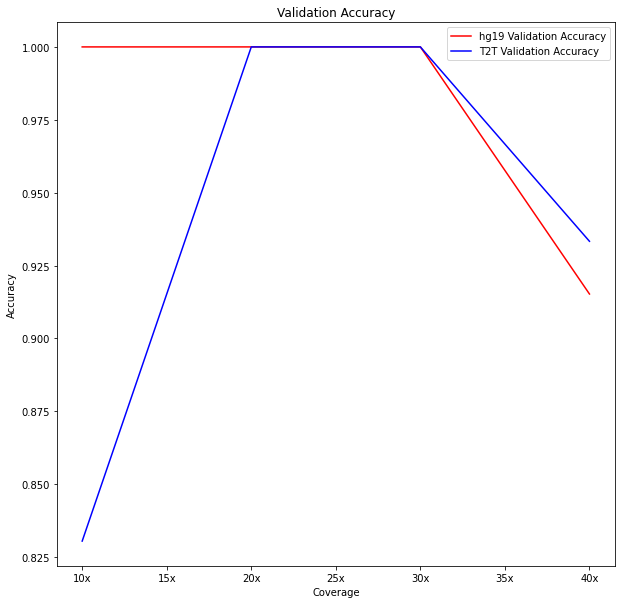

In [ ]:
loss_val = chistory.history['val_accuracy']

loss_val2 = chistory2.history['val_accuracy']

loss_val3 = chistory3.history['val_accuracy']

loss_val4 = chistory4.history['val_accuracy']


tloss_val = tchistory.history['val_accuracy']

tloss_val2 = tchistory2.history['val_accuracy']

tloss_val3 = tchistory3.history['val_accuracy']

tloss_val4 = tchistory4.history['val_accuracy']


loss_valls = [loss_val4, loss_val3, loss_val2, loss_val]
last_losses = []
for i in loss_valls:
  last_loss = i[-1]
  last_losses.append(last_loss)
tloss_valls = [tloss_val, tloss_val2, tloss_val3, tloss_val4]
tlast_losses = []
for i in tloss_valls:
  tlast_loss = i[-1]
  tlast_losses.append(tlast_loss)

import matplotlib.pyplot as plt
print(last_losses)
print(tlast_losses)
nfolds = range(1, 5)
fig,ax = plt.subplots()
fig.canvas.draw()
labels = ['0', '10x', '15x', '20x', '25x', '30x', '35x', '40x']
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(nfolds, last_losses, 'r', label='hg19 Validation Accuracy')
plt.plot(nfolds, tlast_losses, 'b', label='T2T Validation Accuracy')
ax.set_xticklabels(labels)
plt.title('Validation Accuracy')

plt.xlabel('Coverage')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

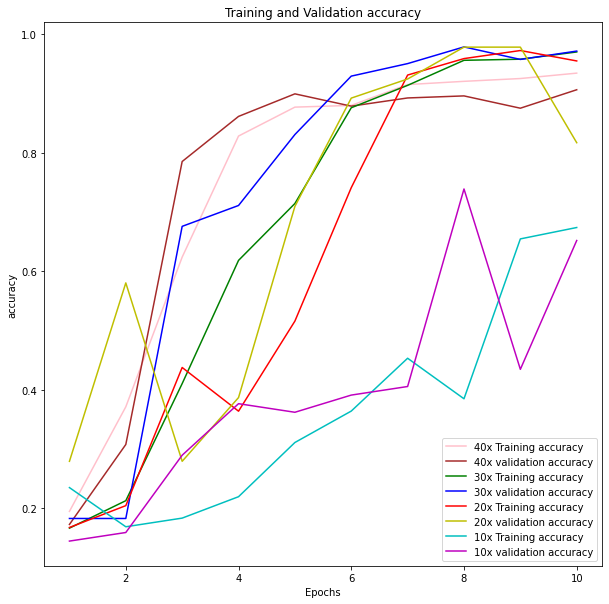

In [ ]:
import matplotlib.pyplot as plt

loss_train = chistory.history['accuracy']

loss_val = chistory.history['val_accuracy']

loss_train2 = chistory2.history['accuracy']

loss_val2 = chistory2.history['val_accuracy']

loss_train3 = chistory3.history['accuracy']

loss_val3 = chistory3.history['val_accuracy']

loss_train4 = chistory4.history['accuracy']

loss_val4 = chistory4.history['val_accuracy']


epochs = range(1,11)
plt.rcParams['figure.figsize'] = [10, 10]


plt.plot(epochs, loss_train, 'pink', label='40x Training accuracy')

plt.plot(epochs, loss_val, 'brown', label='40x validation accuracy')

plt.plot(epochs, loss_train2, 'g', label='30x Training accuracy')

plt.plot(epochs, loss_val2, 'b', label='30x validation accuracy')

plt.plot(epochs, loss_train3, 'r', label='20x Training accuracy')

plt.plot(epochs, loss_val3, 'y', label='20x validation accuracy')

plt.plot(epochs, loss_train4, 'c', label='10x Training accuracy')

plt.plot(epochs, loss_val4, 'm', label='10x validation accuracy')


plt.title('Training and Validation accuracy')

plt.xlabel('Epochs')

plt.ylabel('accuracy')

plt.legend()

plt.show()

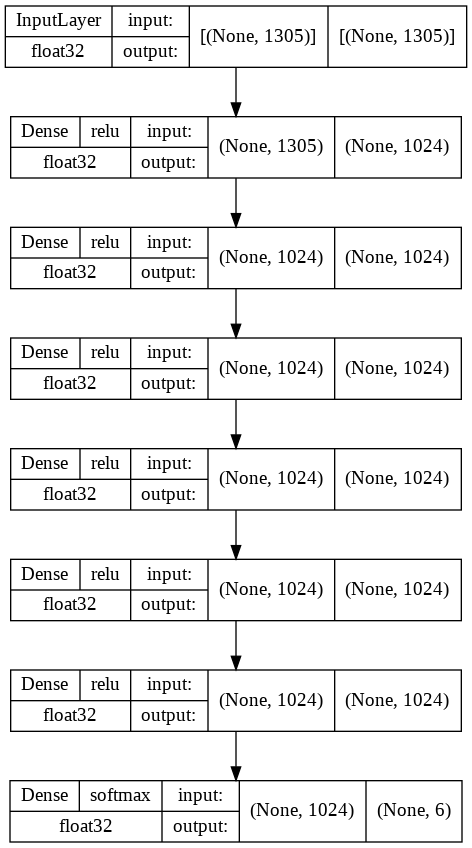

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

The following code can be used to show the number and type of errors from predictions in a given holdout dataset, but wasn't used for the analysis in the poster.

In [ ]:

def genetest(numpredict, modelver, t_train, t_targy):
  Genotypes = ["WTYP_WTYP", "AL37_WTYP", "AL37_AL37", "AL42_WTYP", "AL42_AL42", "AL37_AL42"]
  predictions = modelver.predict(t_train)
  counter = 0
  errors = 0
  for i in predictions[0:numpredict]:
    for index, value in enumerate(i):
      if i[index] > 0.51:
        if Genotypes[int(t_targy[counter])] != Genotypes[index]:
          errors += 1
          print(Genotypes[index])
    counter += 1
  print(str(errors) + " errors")

genetest(100, model3, t3_train, t3_targy)


AL42_WTYP
AL42_WTYP
2 errors
